In [1]:
import numpy as np
import torch
import os
import net
import utils
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from time import time
import pickle
import random
from pathlib import Path

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:
BATCH_SIZE = 32
DS_FOLDER = "/home/ML_courses/03683533_2021/dataset"
LR = 1e-4
DEVICE_ID = 3
VAL_RANGE = 1000
TRAIN_RANGE = None
NUM_WORKERS = 16
NUM_EPOCHS = 20
SHUFFLE = False
RUN_NAME = 'baseline_bn_leakyr_l1'

# Network and optimizer

In [3]:
model = net.AutoEncoder()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device = f'cuda:{DEVICE_ID}' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda:3


AutoEncoder(
  (activation): LeakyReLU(negative_slope=0.01)
  (last_activation): Sigmoid()
  (enc1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (enc1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc5): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc5_bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_runni

# Data Loader & Dataset

In [4]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                ])

class UniDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

In [5]:
val_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[:VAL_RANGE]]
if TRAIN_RANGE != None:
    train_files = [os.path.join(DS_FOLDER,i) for i in 
                   sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:TRAIN_RANGE+1+VAL_RANGE]]
else:
    train_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:]]

In [6]:
val_ds = UniDataset(val_files, transform=transform)
train_ds = UniDataset(train_files, transform=transform)

In [7]:
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=SHUFFLE)

# Train model

In [8]:
def save_imgs(true_imgs, val_imgs, dirname, epoch):
    path = os.path.join('results', RUN_NAME, epoch)
    os.makedirs(path, exist_ok=True)
    save_image(val_imgs, os.path.join(path, 'val_pred.png'))
    save_image(true_imgs, os.path.join(path, 'val_true.png'))

In [9]:
def calc_val_loss(val_dl, epoch, dirname):
    with torch.no_grad():
        val_loss = 0.0
        for images in val_dl:
            images = images.float().to(device)
            outputs = model(images)
            images.require_grad = False
            loss = criterion(outputs, images)
            val_loss += loss.item()
    images = images.cpu()
    outputs = outputs.view(outputs.size(0), 3, 256, 256).cpu().data
    save_imgs(images, outputs, dirname, epoch)
    return val_loss/len(val_dl), make_grid(images), make_grid(outputs)

In [10]:
%%time

train_losses = {}
val_losses = {}
for epoch in range(1, NUM_EPOCHS+1):
    t = time()
    train_loss = 0.0
    for images in tqdm(train_dl):
        images = images.float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss, val_true_grid, val_pred_grid = calc_val_loss(val_dl, str(epoch), RUN_NAME)
    train_loss = train_loss/len(train_dl)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}\t \
    in time {:2f}m'.format(epoch, train_loss, val_loss, (time()-t)/60))


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.07it/s]


Epoch: 1 	Training Loss: 0.124802 	Val Loss: 0.095223	     in time 4.065395m


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.07it/s]


Epoch: 2 	Training Loss: 0.086010 	Val Loss: 0.077884	     in time 4.073012m


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.07it/s]


Epoch: 3 	Training Loss: 0.073834 	Val Loss: 0.069579	     in time 4.068993m


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.07it/s]


Epoch: 4 	Training Loss: 0.067266 	Val Loss: 0.064791	     in time 4.069366m


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.07it/s]


Epoch: 5 	Training Loss: 0.063419 	Val Loss: 0.061811	     in time 4.070090m


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.07it/s]


Epoch: 6 	Training Loss: 0.061086 	Val Loss: 0.060036	     in time 4.067839m


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.07it/s]


Epoch: 7 	Training Loss: 0.059624 	Val Loss: 0.058828	     in time 4.068518m


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.07it/s]


Epoch: 8 	Training Loss: 0.058498 	Val Loss: 0.057911	     in time 4.071482m


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.07it/s]


Epoch: 9 	Training Loss: 0.057587 	Val Loss: 0.057139	     in time 4.067525m


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.06it/s]


Epoch: 10 	Training Loss: 0.056820 	Val Loss: 0.056458	     in time 4.071755m


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.07it/s]


Epoch: 11 	Training Loss: 0.056211 	Val Loss: 0.055884	     in time 4.066892m


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.07it/s]


Epoch: 12 	Training Loss: 0.055761 	Val Loss: 0.055516	     in time 4.070040m


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.07it/s]


Epoch: 13 	Training Loss: 0.055360 	Val Loss: 0.055097	     in time 4.068749m


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.07it/s]


Epoch: 14 	Training Loss: 0.054961 	Val Loss: 0.054672	     in time 4.070000m


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.06it/s]


Epoch: 15 	Training Loss: 0.054603 	Val Loss: 0.054335	     in time 4.071439m


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.07it/s]


Epoch: 16 	Training Loss: 0.054269 	Val Loss: 0.054052	     in time 4.071432m


100%|███████████████████████████████████████| 1219/1219 [04:00<00:00,  5.08it/s]


Epoch: 17 	Training Loss: 0.053961 	Val Loss: 0.053713	     in time 4.062721m


100%|███████████████████████████████████████| 1219/1219 [03:59<00:00,  5.08it/s]


Epoch: 18 	Training Loss: 0.053649 	Val Loss: 0.053420	     in time 4.059059m


100%|███████████████████████████████████████| 1219/1219 [03:59<00:00,  5.08it/s]


Epoch: 19 	Training Loss: 0.053341 	Val Loss: 0.053151	     in time 4.060118m


100%|███████████████████████████████████████| 1219/1219 [03:59<00:00,  5.08it/s]


Epoch: 20 	Training Loss: 0.053031 	Val Loss: 0.052892	     in time 4.058250m
CPU times: user 1h 4min 44s, sys: 19min 52s, total: 1h 24min 37s
Wall time: 1h 21min 21s


# Results

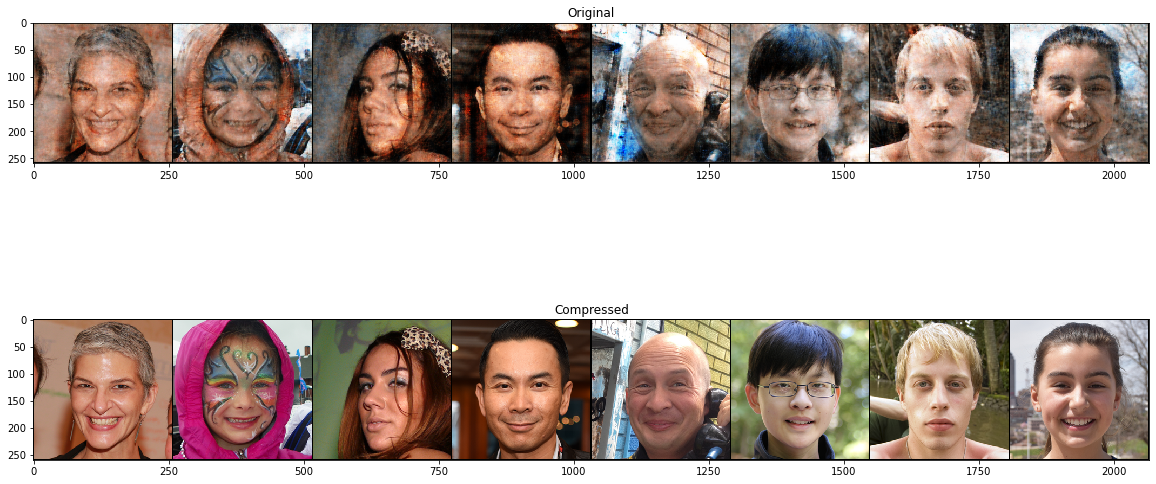

In [11]:
utils.show(val_true_grid, val_pred_grid)

In [12]:
path = Path("results") / RUN_NAME

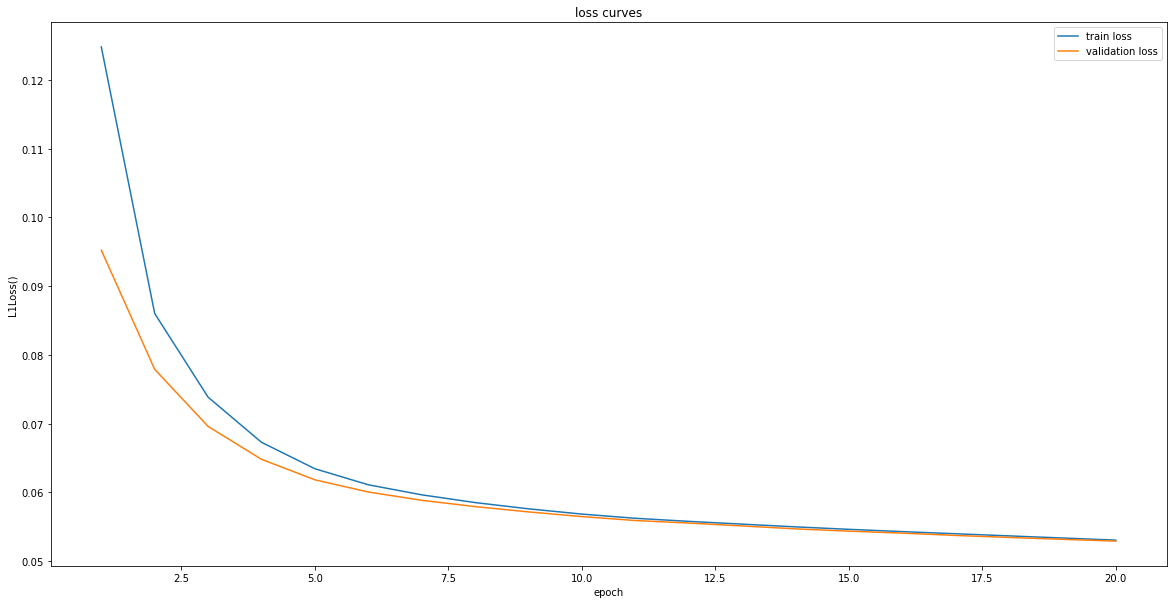

In [13]:
utils.plot_loss(criterion, train_losses, val_losses, path)

In [14]:
utils.write_losses(path, train_losses, val_losses)

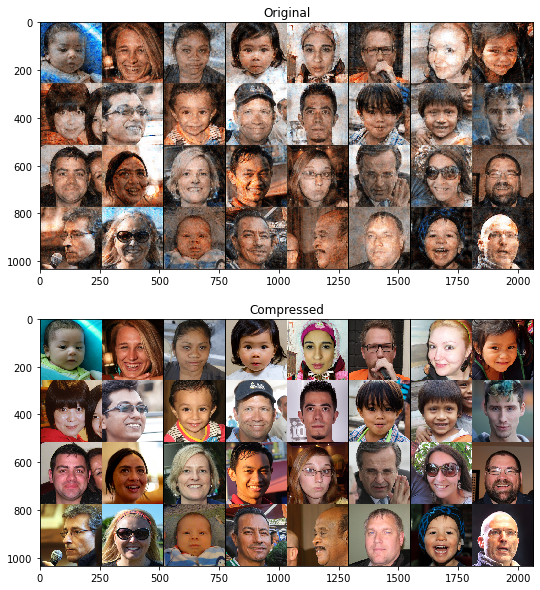

In [15]:
images = list(val_dl)[0]
outputs = model(images.to(device)).cpu()
utils.show(make_grid(images), make_grid(outputs), save=True, path=path)